In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from XRBID.DataFrameMod import Find
from acstools import acszpt
from XRBID.AutoPhots import Zeropoint, RunPhots
import os
import glob
import shutil

# from astroquery.mast import Observations
from astropy.io import fits
# from astropy.stats import sigma_clipped_stats, SigmaClip

# from photutils.detection import DAOStarFinder
# from photutils.aperture import CircularAperture, aperture_photometry
# from photutils.background import Background2D, MedianBackground
# from photutils.utils import calc_total_error

from perform_photometry import find_objects

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandradir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

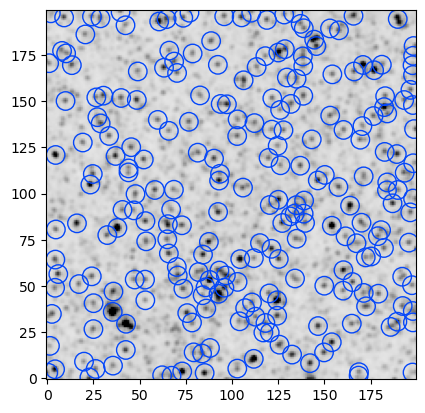

In [4]:
from XRBID.AutoPhots import DaoFindObjects
    

data = fits.getdata(f200w)
data = data[3200:3400, 3200:3400]
objects = DaoFindObjects(data, fwhm=0.14, pixtoarcs=0.031, vmax=10, plot=True)

In [93]:
from photutils.aperture import aperture_photometry, CircularAperture
from photutils.utils import calc_total_error

def perform_photometry(data_sub, data, hdu, apertures, instrument, filter, type, gal, suffix="", calc_error=True, savefile=True):
    '''
    A helper function to calculate the aperture photometry.
	
	PARAMETERS
	----------
	data_sub  [nd.array] : Background subtracted data
	apertures      [int] : the aperture size passed for performing the aperture photometry
	type           [str] : the type of photometry being performed -- full, extended or source
	savefile      [bool] (True): Save the outputs from aperture photometry
	
    RETURNS
	-------
	photometry   [array] : The photometric information of the sources. 
	
	OTHER PRODUCTS
	-------------------
    Region file for all daofind sources in the field in fk5 coordinates.
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_full[SUFFIX].ecsv: 
    Datafile containing the full 1-30 pixel aperture photometry of all sources in the field
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_sources[SUFFIX].ecsv: 
    Datafile containing the 3 pixel aperture photometry of all sources in the field
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_extended[SUFFIX].ecsv: 
    Datafile containing the extended pixel aperture photometry of all sources in the field
    '''
    hst_instrument = ['acs', 'wfc3']
    if calc_error:  # If error needs to be calculated (this is mainly for extended and source photometry)
        # If hst instrument
        if instrument in hst_instrument: 
            photometry = aperture_photometry(data_sub, apertures, error=calc_total_error(data, \
                            data-data_sub, effective_gain=hdu[0].header["EXPTIME"]))
            
        else: # If jwst instrument
                photometry = aperture_photometry(data_sub, apertures, error=calc_total_error(data, \
                            data-data_sub, effective_gain=hdu[1].header["XPOSURE"]))

    else: # if you dont need to calculate error
            photometry = aperture_photometry(data_sub, apertures, method='center')

    if savefile:
        photometry.write("photometry_"+gal+"_"+filter.lower()+"_"+instrument.lower()+"_"+type+suffix+".ecsv", overwrite=True)
        print("photometry_"+gal+"_"+filter.lower()+"_"+instrument.lower()+"_"+type+suffix+".ecsv", "saved")
         
    return photometry

# Create Apertures
def create_apertures(positions, rad_list=(1, 31)):
    ap_rads = [i for i in range(1,31)]
    apertures_full = [CircularAperture(positions, r=r) for r in ap_rads]
    apertures_source = CircularAperture(positions, r=3) # 3px aperture photometry used for sources by default
    apertures_extended = CircularAperture(positions, r=10) # aperture photometry for clusters (default is 10 pixels)
    return apertures_full, apertures_source, apertures_extended


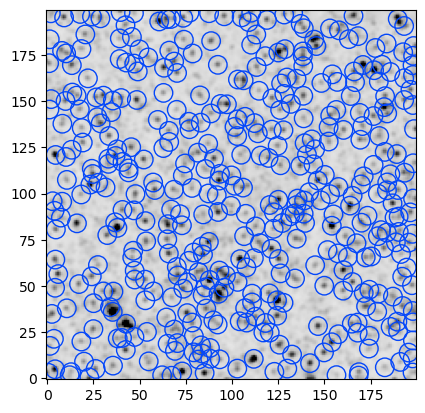

Background subtraction successful
Photometry...
photometry_M66_f200w_nircam_full.ecsv saved
photometry_M66_f200w_nircam_sources.ecsv saved
photometry_M66_f200w_nircam_extended.ecsv saved


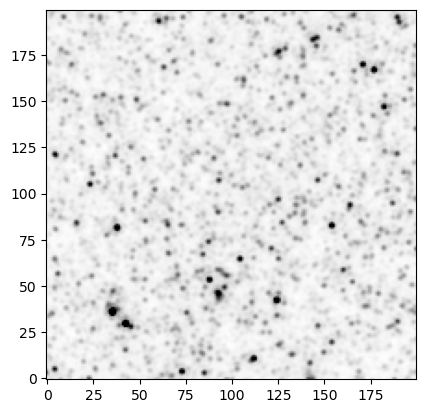

In [5]:
from XRBID.AutoPhots import DaoFindObjects, SubtractBKG, perform_photometry
from photutils.aperture import CircularAperture

min_rad=3
extended_rad=10
instrument='nircam'
gal="M66"
hdu = fits.open(f200w)
data = fits.getdata(f200w)
data = data[3200:3400, 3200:3400]
filter='F200W'

# find objects
objects = DaoFindObjects(data, sigma=5, fwhm=0.14, threshold=3, pixtoarcs=0.031, savereg=False, plot=True, vmax=10)

# subtract background
data_sub = SubtractBKG(data)
print("Background subtraction successful")
plt.imshow(data_sub, cmap='gray_r', vmax=10, origin='lower')

# Aperture Corrections
positions = np.transpose((objects['xcentroid'], objects['ycentroid']))
# Create apertures
ap_rads = [i for i in range(1,31)]
apertures_full = [CircularAperture(positions, r=r) for r in ap_rads]
apertures_source = CircularAperture(positions, r=min_rad) # 3px aperture photometry used for sources by default
apertures_extended = CircularAperture(positions, r=extended_rad) # aperture photometry for clusters (default is 10 pixels)

print("Photometry...")
# Generate aperture photometry with the background-subtracted data
# perform_photometry(data_sub, hdu, apertures, instrument, filter, type, gal, suffix="", calc_error=True, savefile=True):
phot_full = perform_photometry(data_sub, data, hdu, apertures_full, instrument=instrument, filter=filter, type='full', gal=gal, calc_error=False)
phot_sources = perform_photometry(data_sub, data, hdu, apertures_source, instrument=instrument, filter=filter, type='sources', gal=gal, calc_error=True)
phot_extended = perform_photometry(data_sub, data, hdu, apertures_extended, instrument=instrument, filter=filter, type='extended', gal=gal, calc_error=True)


In [79]:
hst_814 = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/M66_mosaic_acs_f814w_drc_sci.fits"

In [3]:
from XRBID.AutoPhots import DaoFindObjects, SubtractBKG

min_rad=3
extended_rad=10
instrument='wfc3'
gal="M66"
hdu = fits.open(hst_814)
data = fits.getdata(hst_814)
data = data[700:1100, 3200:3600]
filter='F814W'

# find objects
objects = DaoFindObjects(data, sigma=5, fwhm=0.15, threshold=3, pixtoarcs=0.05, savereg=False, plot=True, vmax=0.3)

# subtract background
data_sub = SubtractBKG(data)
print("Background subtraction successful")
plt.imshow(data_sub, cmap='gray_r', vmax=0.3, origin='lower')

# Aperture Corrections
positions = np.transpose((objects['xcentroid'], objects['ycentroid']))
# Create apertures
# ap_rads = [i for i in range(1,31)]
# apertures_full = [CircularAperture(positions, r=r) for r in ap_rads]
# apertures_source = CircularAperture(positions, r=min_rad) # 3px aperture photometry used for sources by default
# apertures_extended = CircularAperture(positions, r=extended_rad) # aperture photometry for clusters (default is 10 pixels)

# print("Photometry...")
# # Generate aperture photometry with the background-subtracted data
# # perform_photometry(data_sub, hdu, apertures, instrument, filter, type, gal, suffix="", calc_error=True, savefile=True):
# phot_full = perform_photometry(data_sub, data, hdu, apertures_full, instrument=instrument, filter=filter, type='full', gal=gal, calc_error=False)
# phot_sources = perform_photometry(data_sub, data, hdu, apertures_source, instrument=instrument, filter=filter, type='sources', gal=gal, calc_error=True)
# phot_extended = perform_photometry(data_sub, data, hdu, apertures_extended, instrument=instrument, filter=filter, type='extended', gal=gal, calc_error=True)


TabError: inconsistent use of tabs and spaces in indentation (AutoPhots.py, line 159)

In [ ]:
def create_apertures(positions, rad_list, min_rad=3, extended_rad=10):
    ''' 
    A helper function to create apertures for doing the photometry.
    
    PARAMETERS
    ----------
    positions [nd.array] : Positions of the point sources detected through the DAOFind algorithm.
    rad_list  [list] : A list of aperture radii to be used for the photometry.
    min_rad [float] (3) : Minimum radius to be used.
    max_rad [float] (10) : Maximum radius to be used for extended sources
                          (in this case, clusters)
    '''
    apertures_full = [CircularAperture(positions, r=r) for r in rad_list]
    apertures_source = CircularAperture(positions, r=min_rad) # 3px aperture photometry used for sources by default
    apertures_extended = CircularAperture(positions, r=extended_rad) # aperture photometry for clusters (default is 10 pixels)
    return apertures_full, apertures_source, apertures_extended

In [13]:
from XRBID.AutoPhots import create_apertures

# ap1, ap2, ap3 = create_apertures(positions, [i for i in range(0, 10)])

In [14]:
ap_rads = [i for i in range(1, 31)]
a1, a2, a3 = create_apertures(objects, ap_rads)

NameError: name 'objects' is not defined

Running DaoFind. This may take a while...
Saving M66_daofind_f200w_nircam_img.reg
M66_daofind_f200w_nircam_img.reg saved!
Saving M66_daofind_f200w_nircam_fk5.reg
M66_daofind_f200w_nircam_fk5.reg saved!

 338494 sources found.
Background subtraction...
Photometry...
photometry_M66_f200w_nircam_full.ecsv saved
Time for full photometry: 2.4084531982739765 minutes
Time for source photometry: 0.06476328372955323 minutes
Time for extended photometry: 0.100614066918691 minutes
Aperture corrections...


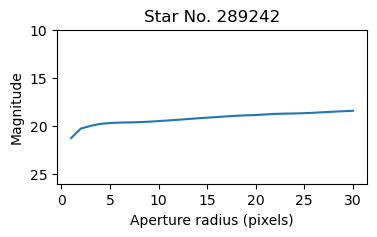

Keep? (yes/[n]o/quit) y


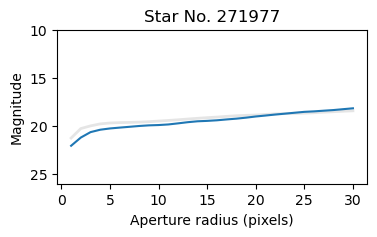

Stars selected: [289242]
19 more to go.


Keep? (yes/[n]o/quit) y


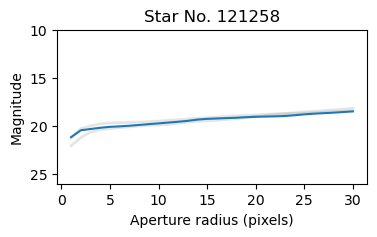

Stars selected: [289242, 271977]
18 more to go.


Keep? (yes/[n]o/quit) y


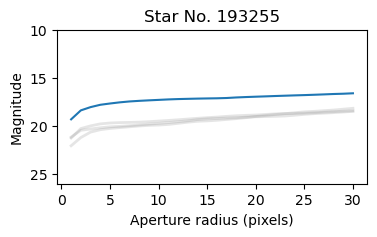

Stars selected: [289242, 271977, 121258]
17 more to go.


Keep? (yes/[n]o/quit) y


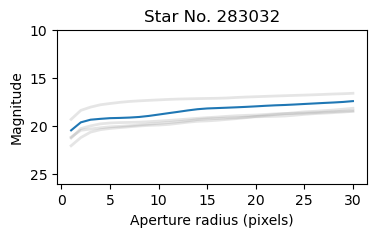

Stars selected: [289242, 271977, 121258, 193255]
16 more to go.


Keep? (yes/[n]o/quit) y


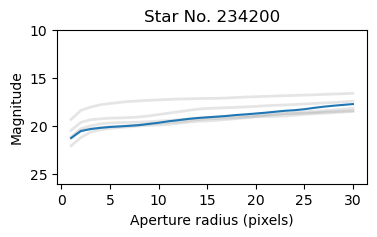

Stars selected: [289242, 271977, 121258, 193255, 283032]
15 more to go.


Keep? (yes/[n]o/quit) y


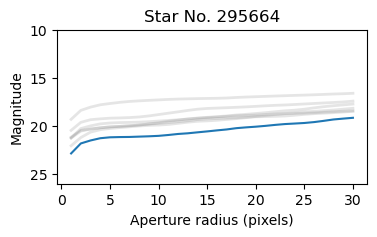

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200]
14 more to go.


Keep? (yes/[n]o/quit) y


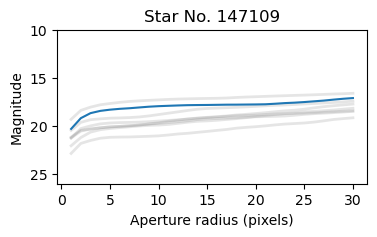

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664]
13 more to go.


Keep? (yes/[n]o/quit) y


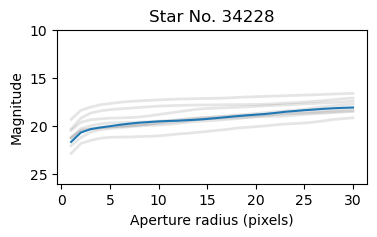

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109]
12 more to go.


Keep? (yes/[n]o/quit) y


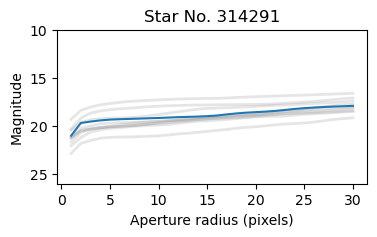

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228]
11 more to go.


Keep? (yes/[n]o/quit) y


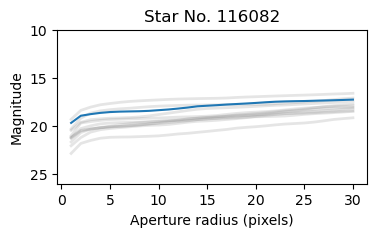

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291]
10 more to go.


Keep? (yes/[n]o/quit) y


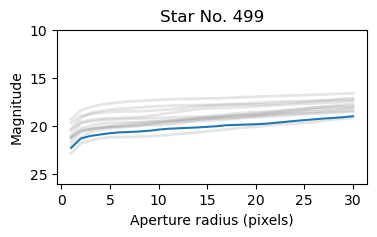

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082]
9 more to go.


Keep? (yes/[n]o/quit) y


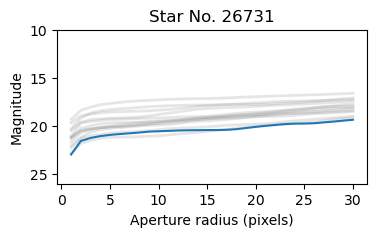

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082, 499]
8 more to go.


Keep? (yes/[n]o/quit) y


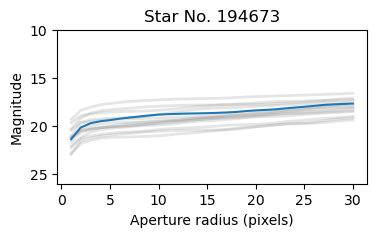

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082, 499, 26731]
7 more to go.


Keep? (yes/[n]o/quit) y


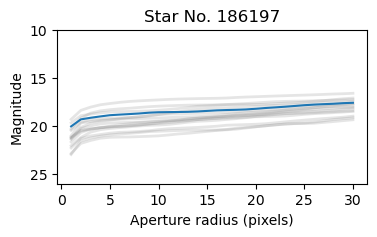

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082, 499, 26731, 194673]
6 more to go.


Keep? (yes/[n]o/quit) y


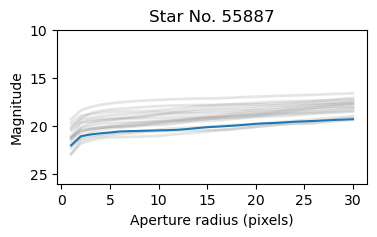

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082, 499, 26731, 194673, 186197]
5 more to go.


Keep? (yes/[n]o/quit) y


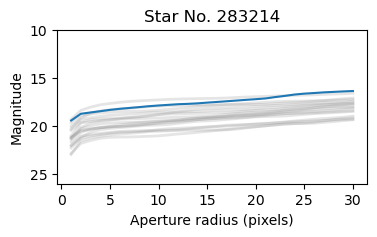

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082, 499, 26731, 194673, 186197, 55887]
4 more to go.


Keep? (yes/[n]o/quit) y


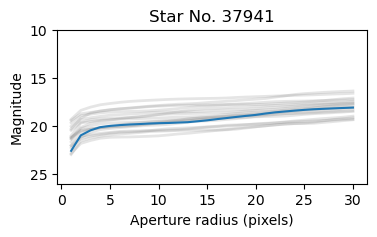

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082, 499, 26731, 194673, 186197, 55887, 283214]
3 more to go.


Keep? (yes/[n]o/quit) y


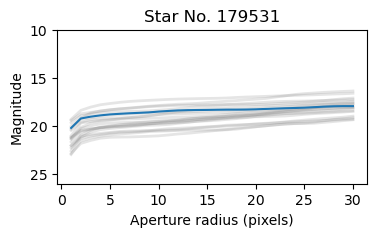

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082, 499, 26731, 194673, 186197, 55887, 283214, 37941]
2 more to go.


Keep? (yes/[n]o/quit) y


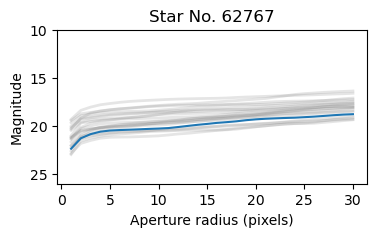

Stars selected: [289242, 271977, 121258, 193255, 283032, 234200, 295664, 147109, 34228, 314291, 116082, 499, 26731, 194673, 186197, 55887, 283214, 37941, 179531]
1 more to go.


Keep? (yes/[n]o/quit) y


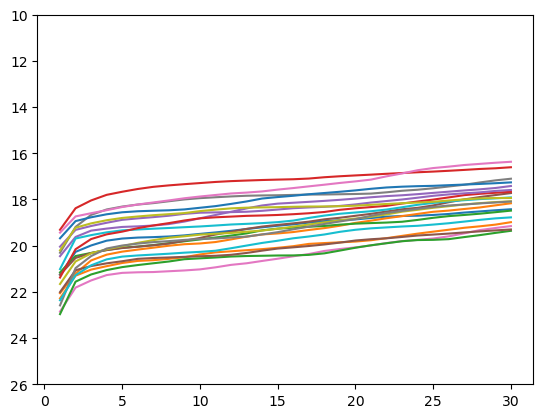

Check all profiles and enter 'y' to continue calculation:  y


Calculating magnitudes...
photometry_M66_f200w_nircam_sources.ecsv saved
photometry_M66_f200w_nircam_extended.ecsv saved
DONE!
CPU times: user 2min 28s, sys: 20.4 s, total: 2min 48s
Wall time: 3min 9s


((np.float64(-1.280280820046783),),
 np.float64(0.24747644447232764),
 np.float64(-0.7081141887840705),
 np.float64(0.2353374715793874))

In [2]:
%%time 
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])

hdu = fits.open(f200w)
RunPhots(hdu, gal='M66', fwhm_arcs=0.14, pixtoarcs=0.031, instrument='nircam', filter='F200W', zeropoint=zeropoint)